In [ ]:
!pip install -U langgraph langchain_openai langchain_community python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 427.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.3/990.3 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.9/378.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.0/337.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "YOUR API KEY"
os.environ["TAVILY_API_KEY"] = "YOUR API KEY"

### Adding Reflection

#### Defining Graph State

In [ ]:
from typing import Annotated, Literal, TypedDict
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

#### Defining Tools

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults


# Define the tools for the agents to use
tools = [TavilySearchResults(max_results=5)]

#### Creating Agents

In [ ]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
    AIMessage
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    if tools:
      return prompt | llm.bind_tools(tools)
    else:
      return prompt | llm

In [ ]:
search_template = """Your job is to search the web for stock market related news that would be relevant to to generate the article described by the user.

                     NOTE: When providing the news articles retrieved to the Outliner, you need to give the Outliner all of the articles you have retrieved that are relevant.
                     The format should be:

                     1. <article 1>
                     2. <article 2>
                     ...
                  """

outliner_template = """Your job is to take as input a list of articles from the web along with users instruction on what article they want to write and generate an outline
                       for the article. This means you are giving clear instructions what information should be included in the article in bullet point format as well as
                       the sources to include in the article.
                    """

writer_template = """Your job is to write an article, do it in this format:

                        TITLE: <title>
                        BODY: <body>

                    You may received feedback on the article from an editor. If you do receive feedback, you MUST make changes to your article and incorporate the feedback.

                       ```
                    """

editor_template = """Your job is to edit an article written by a writer. Please provide constructive critiques so they can improve it for publication.

                    ```EDITORIAL GUIDELINES TO FOLLOW```

                      - Your feedback should be in bullet point format only.

                      - The critiques should only focus on are the use of keywords, the title of the article, and the title of the headers, also make sure they include references.

                      - DO NOT not give positive feedback.

                      - DO NOT WRITE THE ARTICLE. You should only provide feedback in bullet point format.

                      - You should NEVER accept the first draft of the article.


                     If you think the article looks good, then simply say DONE.
                    """

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0)

search_agent = create_agent(
    llm,
    tools,
    system_message=search_template,
)

outliner_agent = create_agent(
    llm,
    [],
    system_message=outliner_template,
)

writer_agent = create_agent(
    llm,
    [],
    system_message=writer_template,
)

editor_agent = create_agent(
    llm,
    [],
    system_message=editor_template,
)

#### Define Nodes

In [ ]:
# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [result]
    }

In [ ]:
import functools

search_node = functools.partial(agent_node, agent=search_agent, name="Search Agent")
outliner_node = functools.partial(agent_node, agent=outliner_agent, name="Outliner Agent")
writer_node = functools.partial(agent_node, agent=writer_agent, name="Writer Agent")
editor_node = functools.partial(agent_node, agent=editor_agent, name="Editor Agent")

In [ ]:
from langgraph.prebuilt import ToolNode

# LangGraph allows for us to create tool nodes
tool_node = ToolNode(tools)

#### Create Conditional Edges

In [ ]:
from langgraph.graph import END, StateGraph

def should_search(state) -> Literal["tools", "outliner"]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return "outliner"

def should_edit(state) -> Literal["writer", END]:
  messages = state['messages']
  last_message = messages[-1]

  if 'DONE' in last_message.content:
    return END

  return "writer"

#### Build  Graph

In [ ]:
# Instantiate a new graph
workflow = StateGraph(AgentState)

# Add the nodes
workflow.add_node("search", search_node)
workflow.add_node("tools", tool_node)
workflow.add_node("outliner", outliner_node)
workflow.add_node("writer", writer_node)
workflow.add_node("editor", editor_node)

# Set the entrypoint as `search`
# This means that this node is the first one called
workflow.set_entry_point("search")
# Add the edges
workflow.add_conditional_edges(
    "search",
    should_search,
)
workflow.add_edge("tools", 'search')
workflow.add_edge("outliner", "writer")
workflow.add_edge("writer", "editor")
workflow.add_conditional_edges(
    "editor",
    should_edit
)

graph = workflow.compile()

#### Visualize Graph

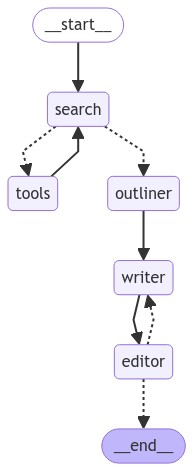

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

#### Test it out!

In [ ]:
from langchain_core.messages import HumanMessage


thread = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="generate an article about tesla that involves elon musk")

for event in graph.stream({"messages": [input_message]}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

generate an article about tesla that involves elon musk
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_HqYNBNSaVVXlyWnn8oW27CsC)
 Call ID: call_HqYNBNSaVVXlyWnn8oW27CsC
  Args:
    query: Tesla Elon Musk news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.theverge.com/2023/3/1/23620698/tesla-master-plan-3-elon-musk-ev-solar-fsd-gigafactory-investor-day", "content": "Elon Musk unveils a new Master Plan, a path to sustainable energy future, but no new cars\nElon Musk unveils a new Master Plan, a path to sustainable energy future, but no new cars\nThe billionaire CEO announced the third part of his company\u2019s \u2018Master Plan,\u2019 outlining plans for a \u2018fully sustainable earth.\u2019 Ikea debuts a trio of affordable smart home s

### Adding Human-in-the-Loop

As you can see from our example with an AI Editor, it posed a few challenges in terms of inefficiency (too many loops + redundant feedback) and the feedback it did give missed key details that a human would not miss.

We will replace the AI editor with you, a human editor, which will provide key feedback to the writer on improving the article.

In [ ]:
from langgraph.checkpoint import MemorySaver

checkpointer = MemorySaver()

graph = workflow.compile(checkpointer=checkpointer, interrupt_before=['editor'])

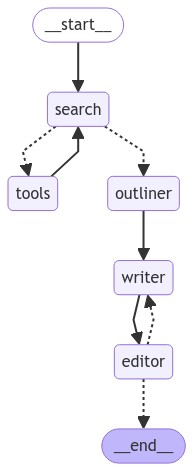

In [ ]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
from langchain_core.messages import HumanMessage


thread = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="generate an article about tesla that involves elon musk")

for event in graph.stream({"messages": [input_message]}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

generate an article about tesla that involves elon musk
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_GgoXsJhkvXkSCVJhnWxqb7jO)
 Call ID: call_GgoXsJhkvXkSCVJhnWxqb7jO
  Args:
    query: Tesla Elon Musk news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.theverge.com/2023/3/1/23620698/tesla-master-plan-3-elon-musk-ev-solar-fsd-gigafactory-investor-day", "content": "Elon Musk unveils a new Master Plan, a path to sustainable energy future, but no new cars\nElon Musk unveils a new Master Plan, a path to sustainable energy future, but no new cars\nThe billionaire CEO announced the third part of his company\u2019s \u2018Master Plan,\u2019 outlining plans for a \u2018fully sustainable earth.\u2019 Ikea debuts a trio of affordable smart home s

In [ ]:
graph.update_state(thread, {"messages": HumanMessage(content="For the article sections, write in paragraph format and don't copy the outline. Keep the sources at the bottom of the article. Make the article only about the Robotaxis")}, as_node="editor")

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef5041e-13ae-692e-8006-967229974ea2'}}

In [ ]:
graph.get_state(thread).next

('writer',)

In [ ]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

TITLE: Tesla's Vision for Robotaxis: Elon Musk's Strategy for Future Mobility

BODY:
In a strategic shift towards the future of transportation, Tesla, led by CEO Elon Musk, is placing a significant focus on the development of robotaxis. As the landscape of electric vehicle sales evolves, Tesla is positioning itself to revolutionize the way people move from place to place with autonomous vehicles. Elon Musk's vision for robotaxis represents a bold step towards redefining urban mobility and reducing the reliance on traditional car ownership models.

The concept of robotaxis involves deploying self-driving vehicles that can operate without human intervention, offering on-demand transportation services to passengers. Tesla's foray into this arena signals a departure from the conventional approach to personal vehicle ownership, with a vision of a shared mobility ecosystem powered by autonomous technology. By l

In [ ]:
graph.update_state(thread, {'messages': HumanMessage(content="DONE")}, as_node="editor")

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef5041e-42d9-693a-8008-a643ba4e8c28'}}

In [ ]:
graph.get_state(thread).next

()

### Adding Custom Tools

We will add a tool to the editor that if called will format the article into JSON format and "publish" it. Once this tool node is called the graph ends.

#### Create New Tool

In [ ]:
from langchain_core.tools import tool
import time
import json


@tool
def publish_article(
    title: str,
    body: str,
    references: list[str]
):
    """Use this to publish the article"""

    return {
        "timestamp": time.time(),
        "title": title,
        "body": body,
        "references": references
    }

#### Create Publisher Node

In [ ]:
publisher = create_agent(
    llm,
    [publish_article],
    system_message="Your job is to use the publish_article tool to publish the final draft of the article outputted by the writer. Please return just the output from the publish_article tool in JSON format."
)

publisher = functools.partial(agent_node, agent=publisher, name="Publisher")

#### Add Tool Node for Publish Article

In [ ]:
publish_tool = ToolNode([publish_article])

#### Modify & Add Conditional Edges

In [ ]:
# Define the function that determines whether to continue or not
def should_edit(state) -> Literal["writer", "publisher"]:
    messages = state['messages']
    last_message = messages[-1]
    # If the editor writes DONE in the text, then we END
    if 'DONE' in last_message.content:
        return "publisher"
    # Otherwise, we pass info back to the writer (reply to the user)
    return 'writer'

# Define the function that determines whether to continue or not
def should_publish(state) -> Literal["publish_tool", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "publish_tool"
    # Otherwise, we stop (reply to the user)
    return END

#### Modify Graph

In [ ]:
from langgraph.checkpoint import MemorySaver

# Instantiate a new graph
workflow = StateGraph(AgentState)

# Add the nodes
workflow.add_node("search", search_node)
workflow.add_node("tools", tool_node)
workflow.add_node("outliner", outliner_node)
workflow.add_node("writer", writer_node)
workflow.add_node("editor", editor_node)
workflow.add_node("publisher", publisher)
workflow.add_node("publish_tool", publish_tool)

# Set the entrypoint as `search`
# This means that this node is the first one called
workflow.set_entry_point("search")
# Add the edges
workflow.add_conditional_edges(
    "search",
    should_search,
)
workflow.add_edge("tools", 'search')
workflow.add_edge("outliner", "writer")
workflow.add_edge("writer", "editor")
workflow.add_conditional_edges(
    "editor",
    should_edit
)

workflow.add_conditional_edges(
    "publisher",
    should_publish
)
workflow.add_edge("publish_tool", "publisher")

# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer, interrupt_before=['editor'])

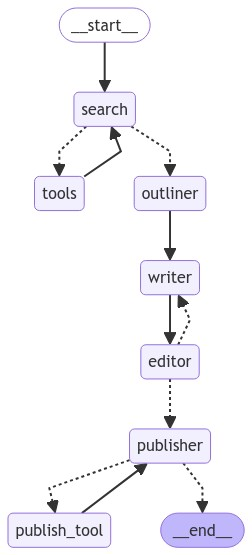

In [ ]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

#### Test it out!

In [ ]:
thread = {"configurable": {"thread_id": 2, "recursion_limit": 150}}
input_message = HumanMessage(content="generate an article about tesla that involves elon musk")


for event in graph.stream({"messages": [input_message]}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

generate an article about tesla that involves elon musk
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_QJsV5zcUNqTlT1Q5uXP4vh7w)
 Call ID: call_QJsV5zcUNqTlT1Q5uXP4vh7w
  Args:
    query: Tesla Elon Musk news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.bbc.com/news/articles/cz5reve8476o", "content": "Tesla boss Elon Musk says the electric car maker will start producing and using humanoid robots from next year. In a social media post, Mr Musk said the robots will first be used by Tesla, which ..."}, {"url": "https://www.theverge.com/2023/3/1/23620698/tesla-master-plan-3-elon-musk-ev-solar-fsd-gigafactory-investor-day", "content": "Elon Musk unveils a new Master Plan, a path to sustainable energy future, but no new cars\nElon Musk unvei

In [ ]:
graph.update_state(thread, {"messages": HumanMessage(content='DONE')}, as_node="editor")

messages = []
for event in graph.stream(None, thread, stream_mode="values"):
  messages.append(event['messages'][-1])
  event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  publish_article (call_nTATYgi4OLIR55ZKP5ghzvFs)
 Call ID: call_nTATYgi4OLIR55ZKP5ghzvFs
  Args:
    title: The Evolution of Tesla under Elon Musk's Leadership
    body: Tesla, the pioneering electric car manufacturer, has been at the forefront of innovation in the automotive industry, with CEO Elon Musk leading the charge towards a sustainable future. Musk's visionary leadership has not only transformed Tesla into a household name but has also propelled the company into new frontiers of technology and sustainability.

One of the recent groundbreaking announcements by Elon Musk is Tesla's foray into robotics. Musk revealed plans for Tesla to produce and utilize humanoid robots starting next year. These robots are set to revolutionize Tesla's operations, potentially enhancing efficiency and productivity in manufacturing processes. The introduction of humanoid robots underscores Tesla's commitme

In [ ]:
article_json = json.loads(messages[-2].content)
print(json.dumps(article_json, indent=4))

{
    "timestamp": 1722544218.4614549,
    "title": "The Evolution of Tesla under Elon Musk's Leadership",
    "body": "Tesla, the pioneering electric car manufacturer, has been at the forefront of innovation in the automotive industry, with CEO Elon Musk leading the charge towards a sustainable future. Musk's visionary leadership has not only transformed Tesla into a household name but has also propelled the company into new frontiers of technology and sustainability.\n\nOne of the recent groundbreaking announcements by Elon Musk is Tesla's foray into robotics. Musk revealed plans for Tesla to produce and utilize humanoid robots starting next year. These robots are set to revolutionize Tesla's operations, potentially enhancing efficiency and productivity in manufacturing processes. The introduction of humanoid robots underscores Tesla's commitment to pushing the boundaries of technology and automation in the automotive sector.\n\nIn line with Tesla's commitment to sustainability, Elon